# **SDSE Final Project: Predicting Car Fuel Efficiency**
Team 56


Our notebook develops and tests various models to predict a given car's **combined fuel efficiency (MPG)** based on information that is available **before** buying the car:

- Make and type                 (SUV, sedan, etc.)
- Drivetrain                    (FWD, AWD, etc.)
- Engine displacement           (L)
- Number of cylinders           (dimensionless)
- Transmission type             (automatic, manual, etc.)

Why this matters:

- Consumers can estimate real-world fuel costs for a car model even when independent test results are not widely available yet, such with new vehicle models and trims.
- Dealerships and fleet managers can compare many options quickly based on expected efficiency.
- Policy or sustainability teams can more immediately simulate how changing the mix of vehicles (more small engines, more hybrids, etc.) might affect fuel consumption and greenhouse/noise emissions.

The notebook follows the outline specified for the project submissions in the lab session. 

0. Choose performance metric
1. load data
2. split off the test data set
3. Choose the families of model and hyperparameter variations to test.
4. Execute (train and evaluate) models
5. Choose best model and evaluate with test data.

# 0. Performance metric:

Since we are working with a regression model, we will be using the R^2 coefficient of determination as the metric to evaluate all our models.

## 1. Load Data
In this section we:


- **1.1**: import necessary libraries/packages
    - **pandas / numpy** for data manipulation  
    - **matplotlib** for plotting  
    - **scikit‑learn** tools for preprocessing and linear regression  
    - **TensorFlow / Keras** for building neural networks
- read in the data
- clean up the data
- plot data
- reduce number of classes in categories where there are too many (consolidation)





In [2]:
# Imports
# !pip install tensorflow
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import OneHotEncoder, StandardScaler
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.linear_model import LinearRegression, Ridge, Lasso
from sklearn.model_selection import GridSearchCV
from sklearn.feature_selection import SequentialFeatureSelector
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score

import tensorflow as tf
from tensorflow.keras.callbacks import EarlyStopping
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout, BatchNormalization

import keras_tuner as kt


In [3]:
# Load in raw dataset with specs + fuel efficiency
data = pd.read_csv("car_data.csv")
# print("First five rows of data: \n", data.head(5))     # Uncomment if you want a quick peak 

### 1.2: Defining Feature Columns and Target

Next, we decide which columns will be used as inputs (features) and which column is the output (target).

- `categorical` lists all string‑based variables we might want to explore.
- `numerical` contains the numeric engine characteristics that are important for fuel use.
- `output` is the target: combined MPG.
- `categorical_for_model` is a refined list of categorical columns used in the actual model.  
  We keep a fixed set of five categorical variables as required by the project guidelines, and avoid overly specific identifiers which would be difficult to generalize well, such as the model name.

In [4]:
# Define which columns are inputs (X) and which is the target (y)

# Raw categorical columns present in the dataset
categorical = ['type', 'drive', 'make', 'model', 'transmission']

# Raw numerical columns
numerical = ['cylinders', 'displacement']

# Target we want to predict
output = 'combination_mpg'

# Categorical columns we’ll actually use in the model
# (we drop 'model' here to avoid too many one-hot columns)
categorical_for_model = ['type', 'drive', 'fuel_type', 'make', 'transmission']

# Final feature matrix and target vector
X = data[categorical_for_model + numerical]
y = data[output]


### 1.3: Data Cleaning and Preparation

Before training any model, our code handles missing values:

1. **Drop rows with missing target**:  
   If `combination_mpg` is missing, the data is unusable for supervised learning.

2. **Impute numerical features with the mean**:  
   This maintains a baseline that keeps all existing data while avoiding bias towards any existing value.

3. **Impute categorical features with the mode** (most frequent category):  
   This preserves the most likely class and keeps categories consistent.

After cleaning, our code builds:

- `feature_cols`: all columns that will be used as inputs
- `X`: the feature matrix  
- `y`: the target vector

In [5]:
# Data preparation
data = data.dropna(subset=[output])

for col in numerical:
    if col in data.columns:
        data[col] = data[col].fillna(data[col].mean())

for col in categorical_for_model:
    if col in data.columns:
        data[col] = data[col].fillna(data[col].mode()[0])


### 1.4: Consolidating categories with too many classes

We will consolidate the categories "make" and "type". We will ignore the "model" data in the model since each entry is a different model.

The "make" category will be reduced to 3 classes by region of the company:
1. **Asia:** kia, hyundai, genesis, mazda, honda, acura, subaru, mitsubishi, toyota, nissan, infiniti
2. **Europe:** bmw, jaguar, mini, audi, land rover, volvo, volkswagen, aston martin, porsche, bentley, mercedes-benz
3. **America:** chevrolet, jeep, gmc, ford, cadillac, buick, ram, roush performance, chrysler

The "type" category will be reduced to 3 classes by size:
1. **Small:** small sport utility vehicle, subcompact car, compact car, two seater, minicompact car, small station wagon
2. **Medium:** midsize car, standard sport utility vehicle, small pickup truck, midsize station wagon
3. **Large:** large car, minivan, standard pickup truck


In [6]:
# defining region lists for make region categories
asia = ["kia", "hyundai", "genesis", "mazda", "honda", "acura",
    "subaru", "mitsubishi", "toyota", "nissan", "infiniti"]

europe = ["bmw", "jaguar", "mini", "audi", "land rover", "volvo",
    "volkswagen", "aston martin", "porsche", "bentley", "mercedes-benz"]

america = ["chevrolet", "jeep", "gmc", "ford", "cadillac", "buick",
    "ram", "roush performance", "chrysler"]

def consolidate_region(make):
    if make in asia:
        return "asia"
    if make in europe:
        return "europe"
    if make in america:
        return "america"
    return "other"   # just in case

# consolidating make data to make_region
data["make_region"] = data["make"].apply(consolidate_region)

small = ["small sport utility vehicle","subcompact car","compact car",
            "two seater","minicompact car","small station wagon"]
medium = ["midsize car", "standard sport utility vehicle", 
            "small pickup truck", "midsize station wagon"]
large = ["large car", "minivan", "standard pickup truck"]

def consolidate_size(type):
    if type in small:
        return "small"
    if type in medium:
        return "medium"
    if type in large:
        return "large"
    return "other"
        
# consolidating type data to size
data["size"] = data["type"].apply(consolidate_size)


### 1.5: Defining the final feature set for modelling

In [7]:
# ----- Selecting the final feature set for modeling -----

# Consolidated list of categorical features we'll use.
# Cleaned versions of raw columns so the model
# doesn’t explode into too many one-hot encoded columns.
categorical_for_model_consolidated = [
    'size',
    'drive',
    'fuel_type',
    'make_region',
    'transmission'
]

# Combine categorical + numerical features to form the full input (X)
feature_cols = categorical_for_model_consolidated + numerical

# X contains only the columns we want the model to learn from
X = data[feature_cols]

# y is the target we want to predict — combined MPG
y = data[output]

print("Feature columns used for the model:")
print(feature_cols)

print(f"Number of samples after cleaning: {len(X)}")


Feature columns used for the model:
['size', 'drive', 'fuel_type', 'make_region', 'transmission', 'cylinders', 'displacement']
Number of samples after cleaning: 550


## 2. Split off the test dataset:
We use an 80-20 split for creating training and test sets from the main dataset.

In [8]:
# Split into train and test sets
# - Train: used to fit / tune models
# - Test: held out until the very end to estimate real-world performance
X_train, X_test, y_train, y_test = train_test_split(
    X, y,
    test_size=0.2,     # 20% of rows are used for final evaluation
    random_state=42    # fixed seed for reproducible results
)

print(f"Train size: {X_train.shape[0]} samples")
print(f"Test size: {X_test.shape[0]} samples")

Train size: 440 samples
Test size: 110 samples


### 2.1: One-hot encoding
Machine learning models like linear regression work with numbers, not strings.  
We therefore need to convert categorical features into a numeric format that a ML model can understand.

We use:

- **`ColumnTransformer` with `OneHotEncoder`**  
  - Each categorical column is expanded into one binary column per category.
  - `handle_unknown='ignore'` ensures the model can handle categories that only appear in the test set.

In [9]:
# One-hot encode the categorical columns and keep numeric ones as they are.
# The preprocessor will be reused for all downstream models.

preprocessor = ColumnTransformer(
    transformers=[
        # 'cat' transformer:
        #   - OneHotEncoder turns each category into a binary column
        #   - handle_unknown='ignore' lets us safely see unseen categories in test data
        ('cat', OneHotEncoder(handle_unknown='ignore'), categorical_for_model_consolidated)
    ],
    remainder='passthrough'  # numerical columns go through unchanged
)

# Fit preprocessor ONLY on training data to avoid data leakage
preprocessor.fit(X_train)

# Transform train and test sets into numeric matrices
X_train_enc = preprocessor.transform(X_train)
X_test_enc  = preprocessor.transform(X_test)

## 3. Choose families of models & hyperparameter variations to test:

**1. Linear Regression**  
    hyperparameter to optimize: number of features  
    method: forward feature reduction  
**2. Ridge & Lasso regression**  
    hyperparameter to optimize: alpha  
**3. Random forest**  
    hyperparameter to optimize: number of features  
**4. Neural Networks (MLP)**  
    hyperparameters to optimize: number of layers, number of nodes, activation functions  



## 4. Execute (train and evaluate) chosen models:

### 4.1: Linear Regression

We start with a plain **linear regression** model using all encoded features:
- <u>Input</u>: one-hot encoded categorical features + numerical features  
- <u>Goal</u>: find coefficients that best fit `combination_mpg` in a least-squares sense  
- <u>Metric</u>:  $R^2$ on the test set, which tells us how much of the variance in MPG is explained.


In [10]:
# 1. Create a plain linear regression estimator
model_LR = LinearRegression()

# 2. Fit the model on the encoded training data
model_LR.fit(X_train_enc, y_train)

# 3. Predict on the held-out test data
y_pred = model_LR.predict(X_test_enc)

# 4. Compute R^2 on the test set (how much variance in y we explain)
r2 = r2_score(y_test, y_pred)
print(f"Linear Regression  $R^2$ Score on test set: {r2:.3f}")


Linear Regression  $R^2$ Score on test set: 0.660


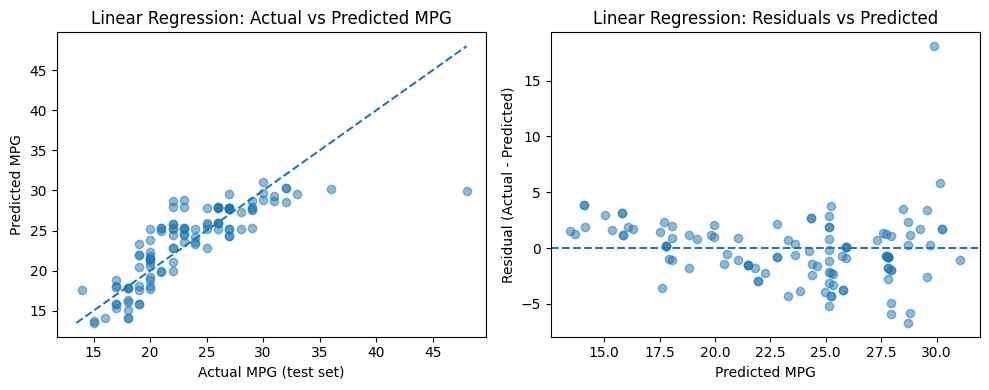

In [11]:
# Visualizing linear-regression performance
fig, (ax1, ax2) = plt.subplots(nrows=1, ncols=2, figsize=(10, 4))
# 1. Predicted vs actual MPG
ax1.scatter(y_test, y_pred, alpha=0.5)
min_val = min(y_test.min(), y_pred.min())
max_val = max(y_test.max(), y_pred.max())
ax1.plot([min_val, max_val], [min_val, max_val], linestyle="--")
ax1.set_xlabel("Actual MPG (test set)")
ax1.set_ylabel("Predicted MPG")
ax1.set_title("Linear Regression: Actual vs Predicted MPG")


# 2. Residuals plot (errors vs prediction)
residuals = y_test - y_pred

ax2.scatter(y_pred, residuals, alpha=0.5)
ax2.axhline(0, linestyle="--")
ax2.set_xlabel("Predicted MPG")
ax2.set_ylabel("Residual (Actual - Predicted)")
ax2.set_title("Linear Regression: Residuals vs Predicted")

plt.tight_layout() # Adjusts subplot params for a tight layout
plt.show()

#### 4.1.1: Linear Regression with forward feature selection

We apply forward feature selection on top of linear regression:

- Start with no features, then greedily add the feature that most improves cross-validated $R^2$.
- Stop when we reach `n_select` features.
- Retrain a linear regression model on this reduced feature set and compare performance.

To optimize the `n_select` hyperparameter, we run a parameter sweep with GridSearchCV(), and then use the best (in terms of $R^2$) `n_select`.

In [ ]:
param_grid = {'sfs__n_features_to_select': (np.linspace(3,14,num=12)).astype(int)}

estimator = model_LR
model = Pipeline([('sfs',SequentialFeatureSelector(estimator, direction='forward', cv=5)),('lr',estimator)])

grid = GridSearchCV(model, param_grid, cv=10, scoring='r2')
grid.fit(X_train_enc, y_train)

n_select = grid.best_params_['sfs__n_features_to_select']

print("Best alpha after parameter optimization: n_features_to_select = ",n_select)
print("Best cross-validation parameter sweep R²:", grid.best_score_)


# running forward FS with optimal number of parameters to remove

#forward selection
# we could use the cv cross validation parameter as a hyperparameter to optimize/play with
sfs_forward = SequentialFeatureSelector(estimator, n_features_to_select=n_select, direction='forward',cv=5)

sfs_forward.fit(X_train_enc,y_train)
# Extract mask of selected features
selected_mask = sfs_forward.get_support()

# Reduce train/test matrices
X_train_fs = X_train_enc[:, selected_mask]
X_test_fs  = X_test_enc[:, selected_mask]

# Fit a new model on selected features
model_LR_fs = LinearRegression()
model_LR_fs.fit(X_train_fs, y_train)

# Predict + evaluate
y_pred_forward = model_LR_fs.predict(X_test_fs)
r2_forward = r2_score(y_test, y_pred_forward)
print(f"Forward Feature Selection Linear Regression $R^2$ Score on test set: {r2_forward:.3f}")

#Get feature names
feature_names = preprocessor.get_feature_names_out()
# print(feature_names)
# Extract selected and removed names
selected_features = feature_names[selected_mask]
removed_features  = feature_names[~selected_mask]

print("Selected features:")
for f in selected_features:
    print(f)

print("Removed features:")
for f in removed_features:
    print(f)



**4.2 Ridge Regression**  
We also try Ridge Regression, which is linear regression with L2 penalty:

- Adds a penalty on large coefficients to reduce overfitting.
- Controlled by hyperparameter α.
- We use cross-validation over several α values and choose the one that gives the best average R².

Best alpha after parameter optimization: alpha =  0.021544346900318832
Best cross-validation parameter sweep R²: 0.7840384868174801
Best Ridge Test R²: 0.660094999140142


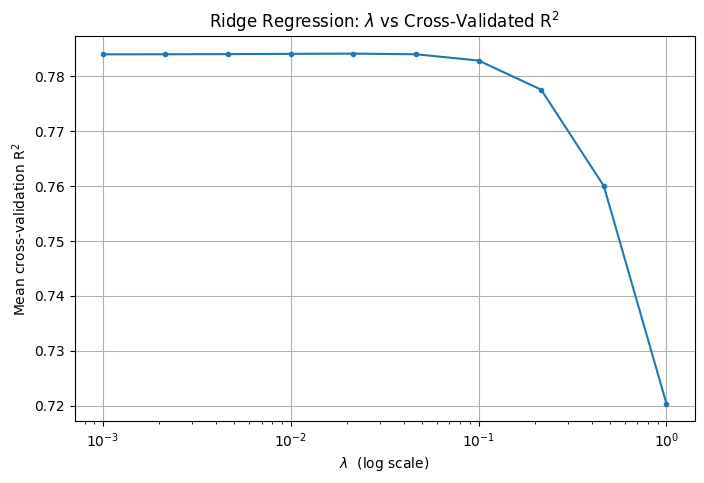

   param_alpha  mean_test_score  std_test_score     alpha
0     0.001000         0.783907        0.097882  0.001000
1     0.002154         0.783920        0.097864  0.002154
2     0.004642         0.783947        0.097825  0.004642
3     0.010000         0.783992        0.097741  0.010000
4     0.021544         0.784038        0.097565  0.021544
5     0.046416         0.783916        0.097197  0.046416
6     0.100000         0.782779        0.096418  0.100000
7     0.215443         0.777474        0.094578  0.215443
8     0.464159         0.759949        0.089243  0.464159
9     1.000000         0.720355        0.073079  1.000000


In [13]:
# Hyperparameter search for Ridge Regression (L2-regularized linear model)
# We search over different alpha values using 5-fold cross-validation

param_grid = {'alpha': np.logspace(-3,3,num=10)}
param_grid = {'alpha': np.logspace(-3,0,num=10)}

model_ridge = Ridge()

grid = GridSearchCV(model_ridge, param_grid, cv=5, scoring='r2')
grid.fit(X_train_enc, y_train)


best_alpha = grid.best_params_['alpha']

print("Best alpha after parameter optimization: alpha = ", best_alpha)
print("Best cross-validation parameter sweep R²:", grid.best_score_)

# creating model_ridge with the optimized alpha value
model_ridge_best = grid.best_estimator_
model_ridge_best.fit(X_train_enc, y_train)

y_pred = model_ridge_best.predict(X_test_enc)
r2 = r2_score(y_test, y_pred)
print("Best Ridge Test R²:", r2)

results_ridge = pd.DataFrame(grid.cv_results_)
results_ridge = results_ridge[['param_alpha', 'mean_test_score', 'std_test_score']]
results_ridge['alpha'] = results_ridge['param_alpha'].astype(float)

# Plot
plt.figure(figsize=(8,5))
plt.plot(results_ridge['alpha'], results_ridge['mean_test_score'], marker='.')

plt.xscale('log')
plt.xlabel('$\lambda$  (log scale)')
plt.ylabel('Mean cross-validation R$^2$')
plt.title('Ridge Regression: $\lambda$ vs Cross-Validated R$^2$')
plt.grid(True)
plt.show()

print(results_ridge)



**4.3: Lasso Regression**

Best alpha after parameter optimization: alpha =  0.001
Best cross-validation parameter sweep $R^2$: 0.7838049580446235
Best Lasso Test $R^2$: 0.6603259182038907


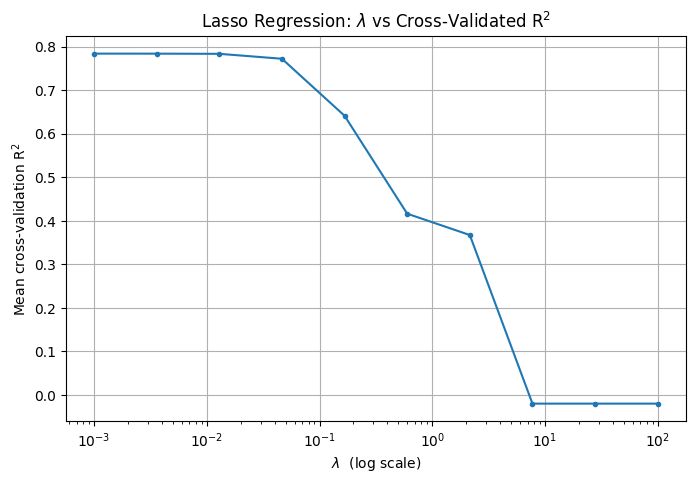

   param_alpha  mean_test_score  std_test_score       alpha
0     0.001000         0.783805        0.098012    0.001000
1     0.003594         0.783752        0.097967    0.003594
2     0.012915         0.783331        0.096575    0.012915
3     0.046416         0.772024        0.084491    0.046416
4     0.166810         0.641142        0.065979    0.166810
5     0.599484         0.416333        0.234600    0.599484
6     2.154435         0.367359        0.207680    2.154435
7     7.742637        -0.019691        0.028371    7.742637
8    27.825594        -0.019691        0.028371   27.825594
9   100.000000        -0.019691        0.028371  100.000000


In [14]:
# lasso model: hyperparameter optimization for alpha

param_grid = {'alpha': np.logspace(-3,2,num=10)}

model_lasso = Lasso()

grid = GridSearchCV(model_lasso, param_grid, cv=5, scoring='r2')
grid.fit(X_train_enc, y_train)


best_alpha = grid.best_params_['alpha']

print("Best alpha after parameter optimization: alpha = ", best_alpha)
print("Best cross-validation parameter sweep $R^2$:", grid.best_score_)

# creating model_lasso with the optimized alpha value
# model_lasso_best = Lasso(alpha=best_alpha)
model_lasso_best = grid.best_estimator_
model_lasso_best.fit(X_train_enc, y_train)

y_pred = model_lasso_best.predict(X_test_enc)
r2 = r2_score(y_test, y_pred)
print("Best Lasso Test $R^2$:", r2)

results_lasso = pd.DataFrame(grid.cv_results_)
results_lasso = results_lasso[['param_alpha', 'mean_test_score', 'std_test_score']]
results_lasso['alpha'] = results_lasso['param_alpha'].astype(float)

# Plot
plt.figure(figsize=(8,5))
plt.plot(results_lasso['alpha'], results_lasso['mean_test_score'], marker='.')

plt.xscale('log')
plt.xlabel('$\lambda$  (log scale)')
plt.ylabel('Mean cross-validation R$^2$')
plt.title('Lasso Regression: $\lambda$ vs Cross-Validated R$^2$')
plt.grid(True)
plt.show()

print(results_lasso)


### 4.4. Random Forest

In [15]:


param_grid = {
    'n_estimators': [100, 200, 300],
    'max_depth': [None, 10, 20],
    'min_samples_leaf': [1, 2, 5]
}

model_rf = RandomForestRegressor(random_state=42, n_jobs=-1)

grid = GridSearchCV(
    model_rf,
    param_grid,
    cv=5,
    scoring='r2',
    n_jobs=-1
)

grid.fit(X_train_enc, y_train)

print("Best RF parameters:", grid.best_params_)
print("Best CV $R^2$ :", grid.best_score_)

Best RF parameters: {'max_depth': 10, 'min_samples_leaf': 1, 'n_estimators': 100}
Best CV $R^2$ : 0.7866166012606441


In [16]:
# Feature importance from Random Forest
feature_names = preprocessor.get_feature_names_out()
best_rf = grid.best_estimator_

importances = best_rf.feature_importances_

rf_importance_df = pd.DataFrame({
    "feature": feature_names,
    "importance": importances
}).sort_values(by="importance", ascending=False)

print("Top 10 most important features (Random Forest):")
print(rf_importance_df.head(10))


Top 10 most important features (Random Forest):
                       feature  importance
8   cat__fuel_type_electricity    0.507248
15        remainder__cylinders    0.221628
16     remainder__displacement    0.152701
9           cat__fuel_type_gas    0.040695
5               cat__drive_fwd    0.023692
12     cat__make_region_europe    0.007952
1             cat__size_medium    0.006958
2              cat__size_small    0.006548
10    cat__make_region_america    0.005270
3               cat__drive_4wd    0.005173


### 4.5: Neural Networks

To explore non‑linear relationships, we implement four different neural network models:

- **Model A: Simple**:  
  - 1 hidden layer with 32 neurons (ReLU)  
  - Good baseline, fast to train

- **Model B: Deeper**:  
  - Two hidden layers (64 → 32 units)  
  - CAN model, more complex patterns

- **Model C: Regularized with Dropout**:  
  - Same idea as Model B but adds `Dropout(0.25)`  
  - Helps reduce overfitting by randomly dropping neurons during training

- **Model D: Wide with Batch Normalization**:  
  - Two wide layers (128 → 64 units)  
  - `BatchNormalization` after each hidd**en layer  
  - Makes training more stable and can speed up convergence

- **Model E: Hyperparameter-Optimized Neural Network (Keras Tuner)**:  
  Model E extends our neural network exploration by using automated hyperparameter optimization instead of manually chosen architectures. Using Keras Tuner’s Random Search, the model searches over a configurable design space that includes:
	- Network depth: 1–3 hidden layers
	-	Hidden layer width: 32 to 256 units
	-	Activation function: ReLU or Tanh
	-	Dropout usage and rate: optional dropout with rates between 0.1–0.4
	-	Learning rate: log-scaled between 1e-4 and 1e-2

  During tuning, the system evaluates multiple candidate architectures and selects the configuration that minimizes validation MAE. A final model is then rebuilt using the best hyperparameters and retrained on the full training set with early stopping. This approach allows Model E to adaptively discover the most effective architecture for the MPG prediction task—potentially achieving better performance than hand-designed networks (Models A–D), especially when nonlinear interactions are complex or when optimal layer sizes and learning rates are not obvious.


All models use:
- **Optimizer**: Adam
- **Loss**: Mean Squared Error (MSE)
- **Metric**: Mean Absolute Error (MAE), easier to interpret as “average error in MPG”

In [17]:
print("Final input feature dimension:", X_train_enc.shape[1])

Final input feature dimension: 17


In [18]:
# NN models

def build_model_A(input_dim):
    """Model A - Simple 1-hidden-layer network."""
    model = Sequential([
        Dense(32, activation='relu', input_dim=input_dim),
        Dense(1)
    ])
    model.compile(optimizer='adam', loss='mse', metrics=['mae'])
    return model


def build_model_B(input_dim):
    """Model B - Deeper network with two hidden layers."""
    model = Sequential([
        Dense(64, activation='relu', input_dim=input_dim),
        Dense(32, activation='relu'),
        Dense(1)
    ])
    model.compile(optimizer='adam', loss='mse', metrics=['mae'])
    return model


def build_model_C(input_dim):
    """Model C - Adds dropout for regularization."""
    model = Sequential([
        Dense(64, activation='relu', input_dim=input_dim),
        Dropout(0.25),
        Dense(32, activation='relu'),
        Dense(1)
    ])
    model.compile(optimizer='adam', loss='mse', metrics=['mae'])
    return model


def build_model_D(input_dim):
    """Model D - Wide network using batch normalization."""
    model = Sequential([
        Dense(128, activation='relu', input_dim=input_dim),
        BatchNormalization(),
        Dense(64, activation='relu'),
        BatchNormalization(),
        Dense(1)
    ])
    model.compile(optimizer='adam', loss='mse', metrics=['mae'])
    return model


def build_model_E(hp):
    """Model FE — Hyperparameter-tuned network using Keras Tuner."""

    model = Sequential()

    # Number of layers: choose 1–3 hidden layers
    for i in range(hp.Int("num_layers", 1, 3)):
        model.add(Dense(
            units=hp.Int(f"units_{i}", min_value=32, max_value=256, step=32),
            activation=hp.Choice("activation", ["relu", "tanh"])
        ))

        # Optional dropout after each layer
        if hp.Boolean(f"dropout_{i}"):
            model.add(Dropout(rate=hp.Float(f"drop_rate_{i}", 0.1, 0.4, step=0.1)))

    # Output layer
    model.add(Dense(1))

    # Learning rate search
    lr = hp.Float("learning_rate", 1e-4, 1e-2, sampling="log")

    model.compile(
        optimizer=tf.keras.optimizers.Adam(learning_rate=lr),
        loss="mse",
        metrics=["mae"],
    )

    return model

We train each neural network using:

- Early stopping (`EarlyStopping`) with:  
  - `patience=10`: if validation loss does not improve for 10 epochs, training stops  
  - `restore_best_weights=True`: we keep the model from the best epoch

For each model we:

1. Train on the encoded training data with a validation split.
2. Evaluate on the encoded test set to obtain MSE  and MAE.
3. Plot the training and validation loss curves to see whether the model is overfitting or underfitting.

This makes the comparison between different architectures transparent and well‑documented.

In [19]:
# Train and evaluate each neural network variant

callbacks = [
    # Early stopping stops training if val loss doesn't improve for 10 epochs,
    # and restores the weights from the best epoch.
    EarlyStopping(patience=10, restore_best_weights=True)
]

# Build one instance of each model architecture
models = {
    "Model A": build_model_A(X_train_enc.shape[1]),
    "Model B": build_model_B(X_train_enc.shape[1]),
    "Model C": build_model_C(X_train_enc.shape[1]),
    "Model D": build_model_D(X_train_enc.shape[1]),
}

history = {}   # training curves (loss, val_loss)
results = {}   # final test metrics

for name, nn_model in models.items():
    print(f"Training {name}...")
    history[name] = nn_model.fit(
        X_train_enc, y_train,
        validation_split=0.2,
        epochs=100,
        batch_size=32,
        callbacks=callbacks,
        verbose=0
    )
    # Evaluate on test data and store MSE/MAE
    test_mse, test_mae = nn_model.evaluate(X_test_enc, y_test, verbose=0)
    results[name] = (test_mse, test_mae)
    print(f"{name} — Test MAE: {test_mae:.3f}")

tuner = kt.RandomSearch(
    build_model_E,
    objective="val_mae",
    max_trials=10,          # Try 10 different architectures
    executions_per_trial=1, # How many repeated trainings per trial
    directory="ktuner_dir",
    project_name="model_E_mpg"
)

tuner.search(
    X_train_enc, y_train,
    validation_split=0.2,
    epochs=50,
    batch_size=32,
    callbacks=[EarlyStopping(patience=5, restore_best_weights=True)],
    verbose=1
)

best_hp = tuner.get_best_hyperparameters(1)[0]
model_E = tuner.hypermodel.build(best_hp)

history["Model E"] = model_E.fit(
    X_train_enc, y_train,
    validation_split=0.2,
    epochs=100,
    batch_size=32,
    callbacks=[EarlyStopping(patience=8, restore_best_weights=True)],
    verbose=0
)

test_mse_E, test_mae_E = model_E.evaluate(X_test_enc, y_test, verbose=0)
results["Model E"] = (test_mse_E, test_mae_E)

print(f"Model E (Keras Tuner) — Test MAE: {test_mae_E:.3f}")


Training Model A...


c:\Users\laley\AppData\Local\Programs\Python\Python310\lib\site-packages\keras\src\layers\core\dense.py:95: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Model A — Test MAE: 2.897
Training Model B...
Model B — Test MAE: 19.930
Training Model C...
Model C — Test MAE: 22.046
Training Model D...
Model D — Test MAE: 24.906
Reloading Tuner from ktuner_dir\model_E_mpg\tuner0.json
Model E (Keras Tuner) — Test MAE: 1.946


**Visualizing Training Curves**  
Finally, we plot the training loss and validation loss for each model across epochs.

Things to look for:

- If validation loss starts increasing while training loss keeps decreasing, then the model is overfitted.  
- If both losses are high and do not improve, then the model might be underpowered or features might not be informative enough

These plots help justify which neural network architectures are the most appropriate for this prediction task.

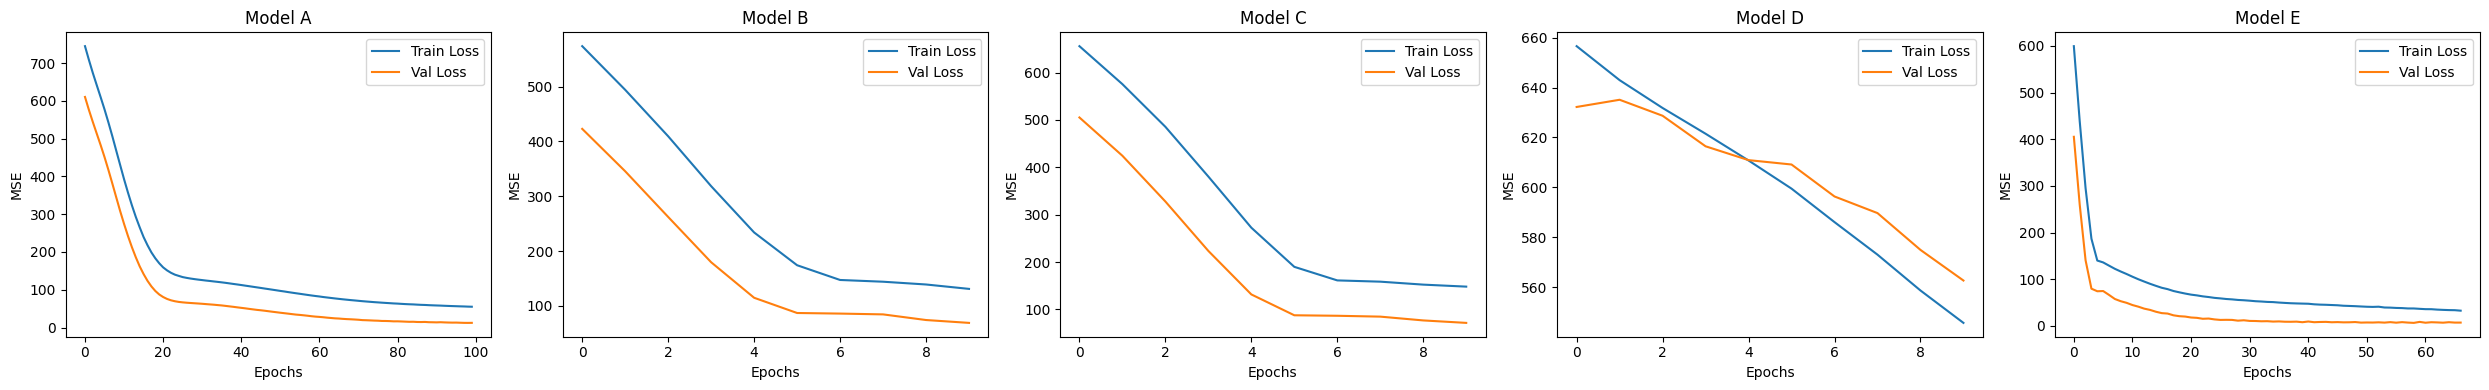

In [20]:
num_models = len(history)

fig, axes = plt.subplots(1, num_models, figsize=(5*num_models, 4))

if num_models == 1:
    axes = [axes]

for ax, name in zip(axes, history.keys()):
    ax.plot(history[name].history['loss'], label='Train Loss')
    ax.plot(history[name].history['val_loss'], label='Val Loss')
    ax.set_title(name)
    ax.set_xlabel("Epochs")
    ax.set_ylabel("MSE")
    ax.legend()

plt.tight_layout()
plt.show()



## 5: Choose best model and evaluate with test data:

In this final section we compare all candidate models on the held-out test set and pick a
single “best” model for predicting combined MPG.

We focus on:

- **R²** – how much of the variance in MPG the model explains  
- **MAE** – average absolute error in MPG (easier to interpret)  
- **RMSE** – root mean squared error (penalizes large mistakes)

Models we compare:

1. **Baseline Linear Regression** (all encoded features)  
2. **Ridge Regression** with the best α value (from Section 4.5)  
3. **Neural Networks (Models A–D)** from Section 4.X  

By evaluating all models on the **same test set**, we can see which one generalizes best,
instead of just memorizing the training data.


In [ ]:
results_summary = []

# 1. Plain Linear Regression
y_pred_lr = model_LR.predict(X_test_enc)
mse_lr = mean_squared_error(y_test, y_pred_lr)
rmse_lr = np.sqrt(mse_lr)

results_summary.append({
    "Model": "Linear Regression",
    "Family": "Linear",
    "R2": r2_score(y_test, y_pred_lr),
    "MAE": mean_absolute_error(y_test, y_pred_lr),
    "RMSE": rmse_lr,
})

# Forward Feature Reduced LR
y_pred_lr_fs = model_LR_fs.predict(X_test_fs)
mse_lr_fs = mean_squared_error(y_test, y_pred_lr_fs)
rmse_lr_fs = np.sqrt(mse_lr_fs)

results_summary.append({
    "Model": "Linear Regression",
    "Family": "Linear",
    "R2": r2_score(y_test, y_pred_lr_fs),
    "MAE": mean_absolute_error(y_test, y_pred_lr_fs),
    "RMSE": rmse_lr_fs,
})


# 2. Best Ridge Regression
model_ridge_best.fit(X_train_enc, y_train)
y_pred_ridge = model_ridge_best.predict(X_test_enc)

mse_ridge = mean_squared_error(y_test, y_pred_ridge)
rmse_ridge = np.sqrt(mse_ridge)

results_summary.append({
    "Model": f"Ridge (alpha={best_alpha})",
    "Family": "Linear (regularized)",
    "R2": r2_score(y_test, y_pred_ridge),
    "MAE": mean_absolute_error(y_test, y_pred_ridge),
    "RMSE": rmse_ridge,
})

# 

# 3. Neural Networks A–D
for name, nn_model in models.items():
    y_pred_nn = nn_model.predict(X_test_enc).flatten()
    mse_nn = mean_squared_error(y_test, y_pred_nn)
    rmse_nn = np.sqrt(mse_nn)

    results_summary.append({
        "Model": name,
        "Family": "Neural Network",
        "R2": r2_score(y_test, y_pred_nn),
        "MAE": mean_absolute_error(y_test, y_pred_nn),
        "RMSE": rmse_nn,
    })

y_pred_E = model_E.predict(X_test_enc).flatten()
mse_E = mean_squared_error(y_test, y_pred_E)
rmse_E = np.sqrt(mse_E)
results_summary.append({
    "Model": "Model E (Keras Tuner)",
    "Family": "Neural Network (Tuned)",
    "R2": r2_score(y_test, y_pred_E),
    "MAE": mean_absolute_error(y_test, y_pred_E),
    "RMSE": rmse_E,
})


results_df = pd.DataFrame(results_summary).sort_values(by="MAE").reset_index(drop=True)

print("Test-set performance of all models:\n")
display(results_df)

best_row = results_df.iloc[0]
print("\nBest overall model on the test set:")
print(f"  {best_row['Model']} "
      f"(Family: {best_row['Family']}) "
      f"— R²={best_row['R2']:.3f}, MAE={best_row['MAE']:.3f}, RMSE={best_row['RMSE']:.3f}")


ValueError: X has 17 features, but LinearRegression is expecting 12 features as input.

The scores show how well each model handled the task of predicting a vehicle’s combined MPG:
- R² tells us how much of the variation in fuel economy the model can explain — higher is better.
- MAE gives the average size of the model’s mistakes in MPG, which is easy to understand in real-world terms.
- RMSE punishes bigger errors more heavily and is a good indicator of how stable the model is across different kinds of cars.

Comparing these models side-by-side reveals which approach generalized best rather than simply memorizing the training data.
The best model delivers the most reliable MPG predictions and is the that would be best for deployment or continued focused refinement.